In [8]:
from script_figure import AIC_length_model_OU as AIC_length_model
import importlib, os
import importlib
import SFFI.util_plot as ut 
from simulation_models import Ornstein_Uhlenbeck
import numpy as np
from dataclasses import dataclass
from script_figure import AIC_length_model_OU as AIC_length_model
import SFFI.util_plot as ut 
import matplotlib.pyplot as plt
import SFFI.SBR_progression as l
from script_cluster.Ornstein_Uhlenbeck_dimension import random_interaction_matrix
from simulation_models.Ornstein_Uhlenbeck import OrnsteinUhlenbeck
import _helper._load_csv as lcsv
import importlib
import os
import matplotlib.pyplot as plt
import matplotx
import script_figure.helper_figure as hf

ut.set_favorite_plot_config()
lcsv.aggreagate_csv_from_cluster(select_file="large", path=os.path.abspath('') + "/csv")

model_class = Ornstein_Uhlenbeck.OrnsteinUhlenbeck

@dataclass
class Data:
    nodes : tuple
    info : float
    info_delta : float
    info_delta_std : float
    i_simu : int
    
def import_simu(dim):
    lcsv.aggreagate_csv_from_cluster(select_file="large_deviation", path=os.path.abspath('') + "/csv")
    def to_tuple(cell):
        # Example of converting a string like "(1, 2)" to a tuple (1, 2)
        if len(cell) <=5 :
            return (int(cell[1:-2]),)
        return tuple(map(int, cell.strip("()").split(",")))
    converters = {"nodes":to_tuple} #"info" : ast.literal_eval, "info_delta" : ast.literal_eval}
    try:
        df = lcsv.read_csv(f"large_deviation_dim_{dim}.pkl")
    except:
        print("read csv")
        df = lcsv.read_csv(f"large_deviation_dim_{dim}.csv", converters=converters)
    return df

def load_model(dim):
    omega = random_interaction_matrix(dim, seed=0)
    model = OrnsteinUhlenbeck(omega=omega, diffusion_strength=0.1, dt=0.01, n=100)
    model_l0, model = AIC_length_model.simu_for_plotting(model=model, seed=0, n=model.n, start=False, systematic_exploration=False)
    return model_l0, model

Look in  /home/andonis/These/Jupyter/PASTIS_PRL_github/csv
['lotka_volterra_dim_7_n.pkl', 'OrnsteinUhlenbeck_repulsive_gaussian_n.pkl', 'OrnsteinUhlenbeck_repulsive_gaussian_diffusion_strength.pkl', 'large_deviation_dim_8.pkl', 'large_deviation_dim_3.pkl', 'large_deviation_dim_6.pkl', 'OrnsteinUhlenbeck_dim_10_n.pkl', 'lotka_volterra_dim_7_benchmark_sindy_n.pkl', 'lorenz_critical_constant_noise_p_n.pkl', 'Misspecified_model_figure_1_diffusion_strength.pkl', 'lotka_volterra_dim_7_p_n.pkl', 'grayscott_dt.pkl', 'OrnsteinUhlenbeck_p_dim_10_n.pkl', 'grayscott_n.pkl', 'grayscott_p_n.pkl', 'grayscott_diffusion_strength.pkl', 'lorenz_critical_constant_noise_n.pkl', 'lorenz_critical_constant_noise_experimental_noise.pkl', 'lorenz_critical_constant_noise_diffusion_vs_time_diffusion_strength.pkl', 'lotka_volterra_dim_7_diffusion_strength.pkl', 'lorenz_critical_constant_noise_dt.pkl', 'large_deviation_dim_7.pkl', 'large_deviation_dim_9.pkl', 'large_deviation_dim_10.pkl', 'large_deviation_dim_5.pkl

In [9]:
def estimation_average(df, key_info = "info_delta"):
    average_info_dict = df.groupby('nodes')[key_info].mean().to_dict()
    return average_info_dict

def estimation_pareto_front(df, key_info = "info_delta"):
    df['nodes_size'] = df['nodes'].apply(len)
    max_info_per_simu = df.groupby(['i_simu', 'nodes_size'])[key_info].max().reset_index()
    average_max_info = max_info_per_simu.groupby('nodes_size')[key_info].mean().to_dict()
    std_max_info = max_info_per_simu.groupby('nodes_size')[key_info].std().to_dict()
    return average_max_info, std_max_info

def variance_between_complet_model(df, model):
    small_nodes_set = set(model.index_real_base)
    df['is_large_set'] = df['nodes'].apply(lambda x: small_nodes_set.issubset(set(x)) and len(set(x)) > len(small_nodes_set))
    large_set_variance = df[df['is_large_set']].groupby('nodes_size').agg(
        info_variance=('info', 'std'),
        info_delta_std=('info_delta', 'std'),
        info_delta_std_esti=('info_delta_std', 'mean')
    )
    return large_set_variance

def estimation_ordered_average(df, key_info="info"):
    df = df.copy()
    df['nodes_size'] = df['nodes'].apply(len)
    df['ordered_position'] = df.groupby(['i_simu', 'nodes_size'])[key_info].rank(method='first', ascending=False)
    df['ordered_key'] = tuple(zip(df['nodes_size'], df['ordered_position'].astype(int)))
    df = df.drop(columns=['nodes', "i_simu"])
    df = df.groupby('ordered_key').mean()
    nodes_size = [key[0] for key in df.index.tolist()]
    info_values = df[key_info].tolist()
    
    return nodes_size, info_values

def add_not_AIC_info(df, model):
    df['nodes_size'] = df['nodes'].apply(len)
    df['info_not_AIC'] = df['info'] + df['nodes_size']
    df['info_delta_not_AIC'] = df['info_delta'] + df['nodes_size'] - len(model.index_real_base)
    return df

In [10]:
dim = 3
key_info = "info_not_AIC"
key_info_delta = "info_delta_not_AIC"

df = import_simu(dim)
model_l0, model = load_model(dim)
df = add_not_AIC_info(df, model)

model_l0.d_information = estimation_average(df, key_info=key_info)
nodes_size, info_values = estimation_ordered_average(df, key_info=key_info)
#nodes_size, info_values = [len(key) for key in model_l0.d_information.keys()], [model_l0.d_information[key] for key in model_l0.d_information.keys()]

average_max_info = estimation_pareto_front(df, key_info=key_info)[0]
info_best_nodes = model_l0.compute_information(tuple(model.index_real_base))

Look in  /home/andonis/These/Jupyter/PASTIS_PRL_github/csv
['lotka_volterra_dim_7_n.pkl', 'OrnsteinUhlenbeck_repulsive_gaussian_n.pkl', 'OrnsteinUhlenbeck_repulsive_gaussian_diffusion_strength.pkl', 'large_deviation_dim_8.pkl', 'large_deviation_dim_3.pkl', 'large_deviation_dim_6.pkl', 'OrnsteinUhlenbeck_dim_10_n.pkl', 'lotka_volterra_dim_7_benchmark_sindy_n.pkl', 'lorenz_critical_constant_noise_p_n.pkl', 'Misspecified_model_figure_1_diffusion_strength.pkl', 'lotka_volterra_dim_7_p_n.pkl', 'grayscott_dt.pkl', 'OrnsteinUhlenbeck_p_dim_10_n.pkl', 'grayscott_n.pkl', 'grayscott_p_n.pkl', 'grayscott_diffusion_strength.pkl', 'lorenz_critical_constant_noise_n.pkl', 'lorenz_critical_constant_noise_experimental_noise.pkl', 'lorenz_critical_constant_noise_diffusion_vs_time_diffusion_strength.pkl', 'lotka_volterra_dim_7_diffusion_strength.pkl', 'lorenz_critical_constant_noise_dt.pkl', 'large_deviation_dim_7.pkl', 'large_deviation_dim_9.pkl', 'large_deviation_dim_10.pkl', 'large_deviation_dim_5.pkl

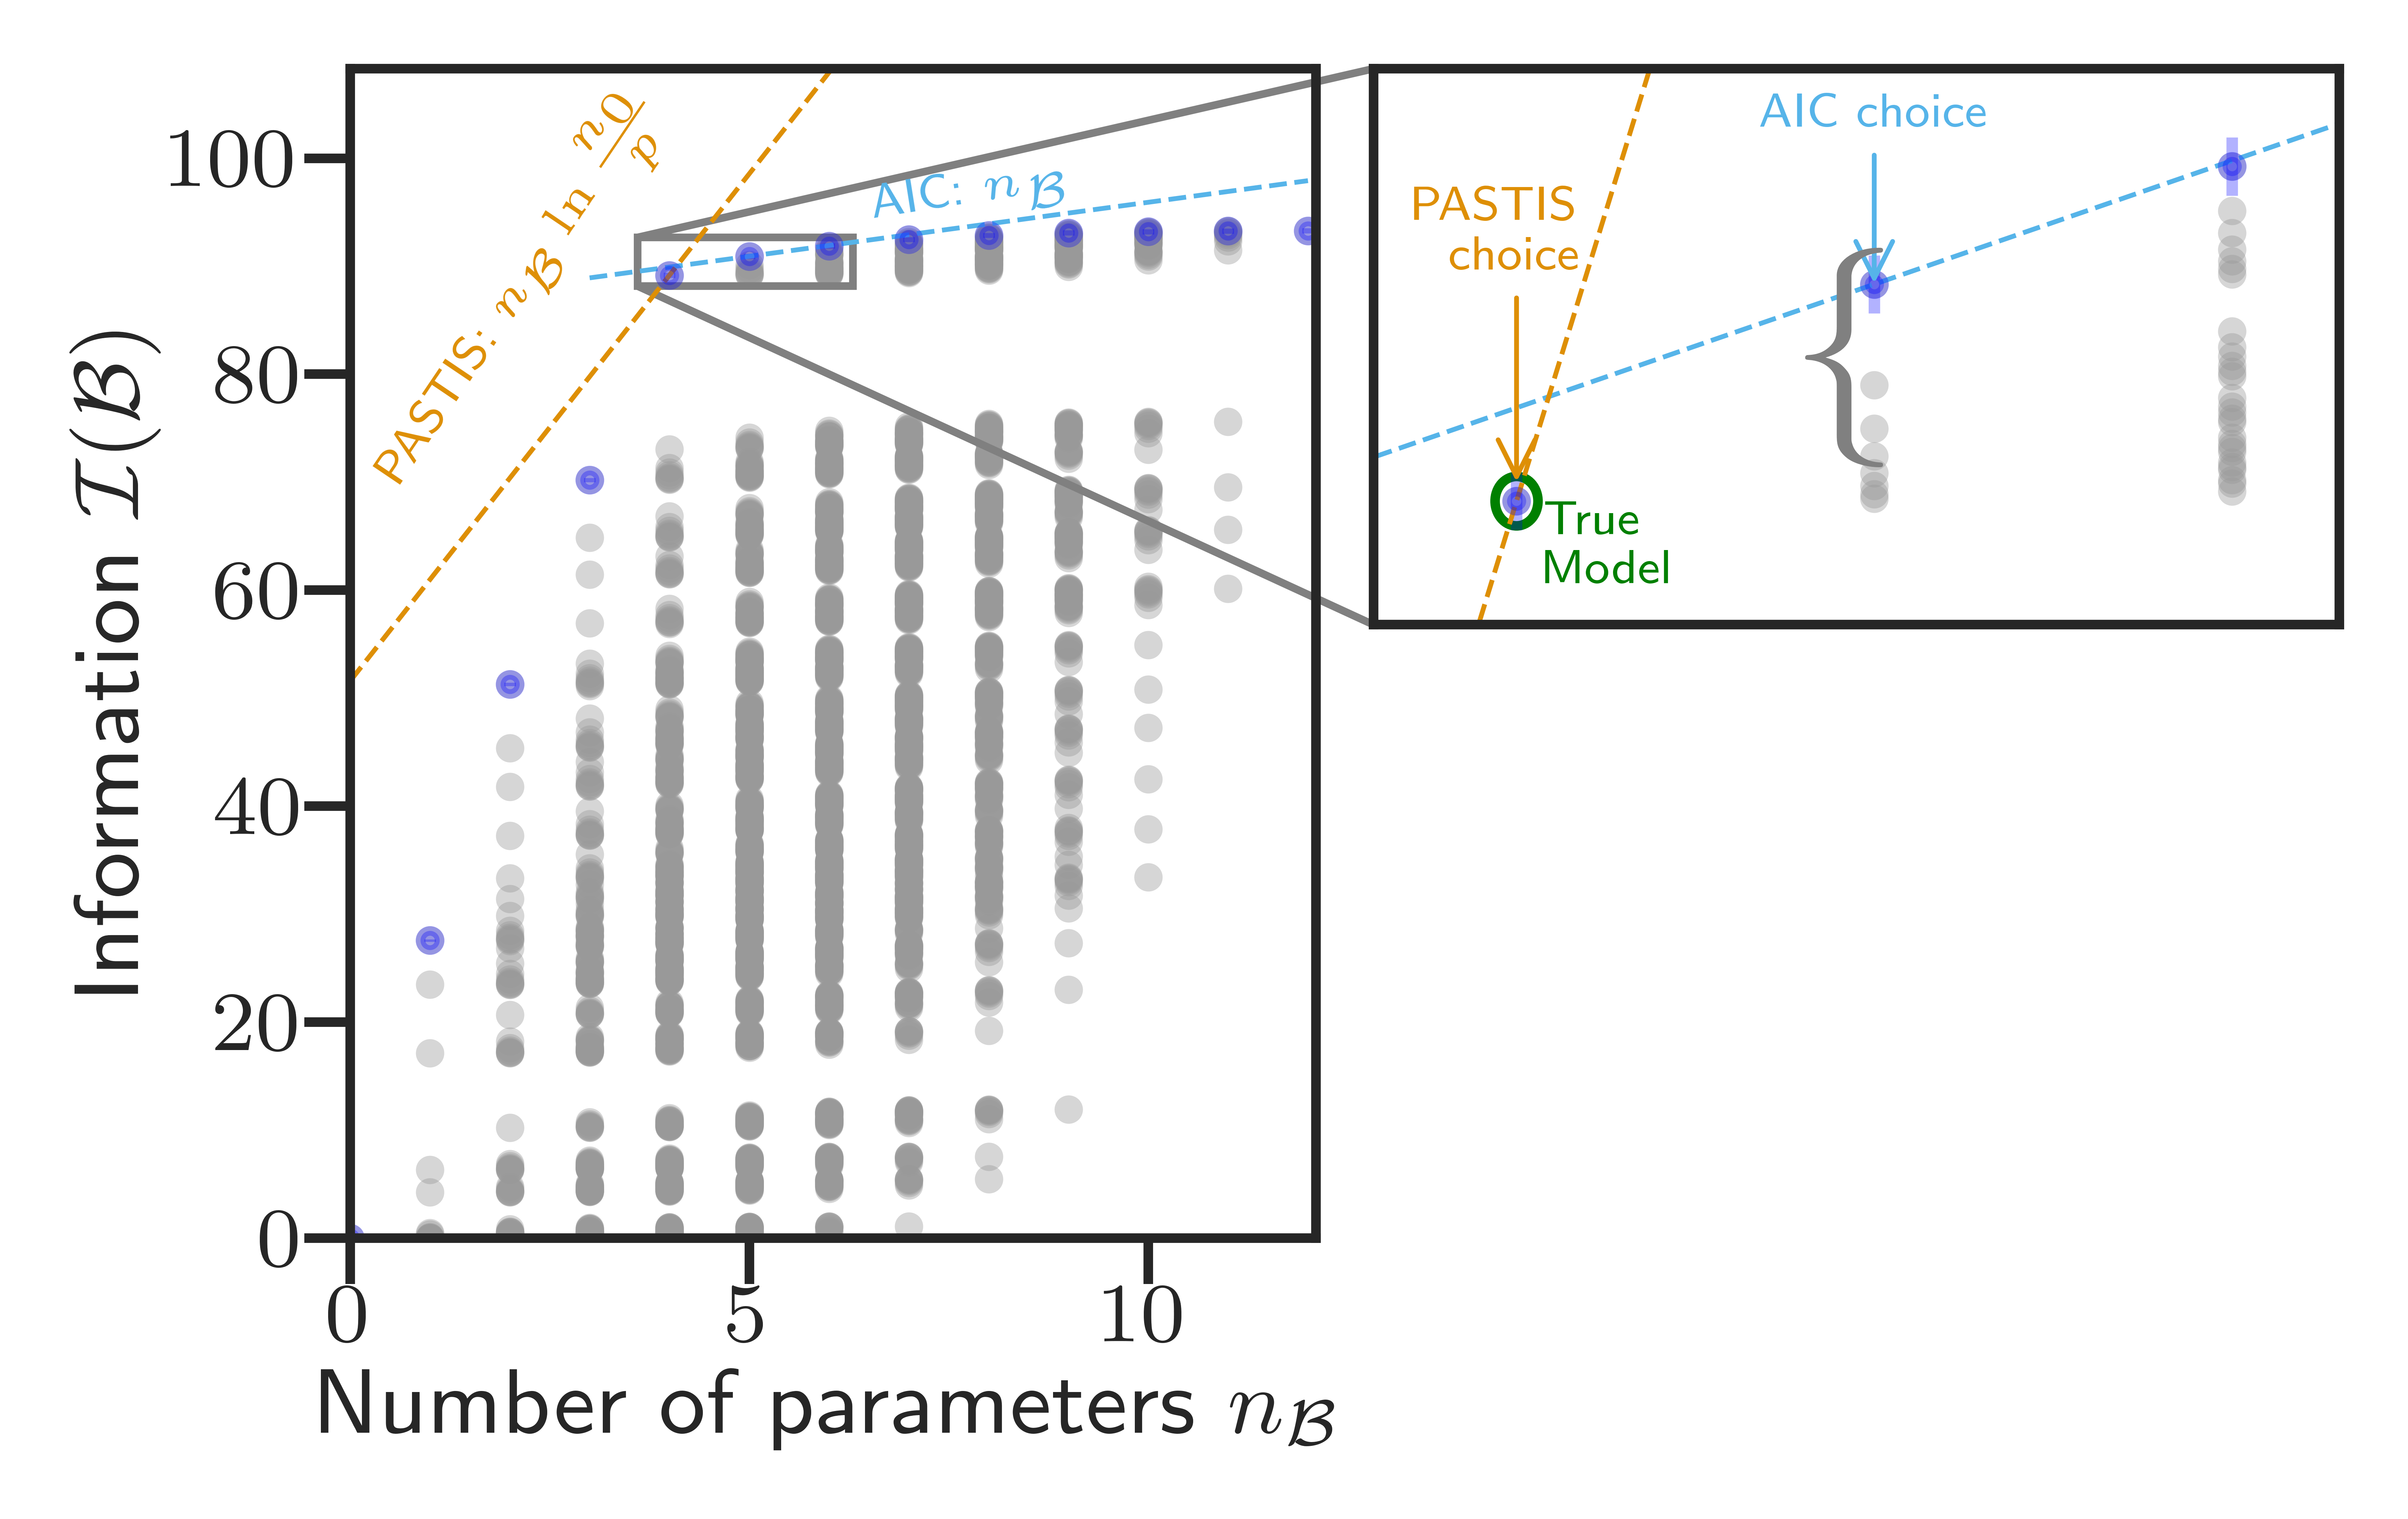

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
from brokenaxes import BrokenAxes
from script_figure import labels_plot
import matplotlib.markers as ma
from matplotlib.patches import Ellipse
# import pylustrator
# pylustrator.start()
importlib.reload(labels_plot)

def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    #inset_axes.add_patch(p1)
    parent_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    parent_axes.add_patch(p2)
    p2.set_clip_on(False)
    
    pp.set_in_layout(False)
    p1.set_in_layout(False)
    p2.set_in_layout(False)

    #return pp, p1, p2

def zoom(ax=None, axins=None, letter="", add_true_model=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(nodes_size, info_values, marker=ma.MarkerStyle(marker=".", fillstyle="full"), alpha=0.4, s=35, linewidths=0, label="$\mathbb{E}[\mathcal{I}]$", color="#999999")#color="#0173B2")
    ax.legend([]).remove()
    if axins is None:
        axins = zoomed_inset_axes(ax, zoom=4, bbox_to_anchor=(2.5,1), bbox_transform=ax.transAxes)  # zoom factor of 2
    axins.scatter(nodes_size, info_values, marker=ma.MarkerStyle(marker=".", fillstyle="full"), alpha=0.4, s=35, linewidths=0, label="$\mathbb{E}[\mathcal{I}]$", color="#999999")#color="#0173B2")
    axins.legend([]).remove()
    info_best_nodes = model_l0.compute_information(tuple(model.index_real_base)) 
    n_star = len(model.index_real_base)
    delta_y = 1
    x1, x2, y1, y2 = n_star-0.4, n_star+2.3, info_best_nodes - delta_y, info_best_nodes + 3.5*delta_y  # Define the region to zoom i7
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_xlabel("")
    axins.set_ylabel("")
    ax.set_ylabel(r"$\text{Information } \mathcal{I}(\mathcal{B})$")
    ax.set_xlabel(r"$\text{Number of parameters } n_\mathcal{B}$")
    out = mark_inset(ax, axins, loc1a=2, loc2a=3, loc1b=2, loc2b=3, fc="none", ec="0.5")    
    return ax, axins, (x2-x1)/(y2-y1)

def add_pareto_front(df, l_ax, key_info="info"):
    ## Add pareto front
    average_max_info, std_max_info = estimation_pareto_front(df, key_info=key_info)
    sizes = list(average_max_info.keys())
    avg_max_info_values = np.array(list(average_max_info.values()))
    std_max_info_values = np.array(list(std_max_info.values()))
    yerr = std_max_info_values/np.sqrt(len(df['i_simu'].unique()))
    for ax in l_ax:
        ax.errorbar(sizes, avg_max_info_values, yerr=yerr, fmt='o', color='blue', alpha=0.3, markersize=2, label=r"$\mathbb{E}[\text{max}(\mathcal{I})]$")
    return average_max_info

def add_text(axsmall, average_max_info, aspect_ratio, fontsize=5):
    x1, x2 = len(model.index_real_base), len(model.index_real_base) + 1
    y1, y2 = average_max_info[x1], average_max_info[x2]
    dx = .02
    dy = 0.3
    axsmall.text(x1 + 9*dx, y1 + 6*dy, 'PASTIS\nchoice', ha='right', va='bottom', color=labels_plot.color_dict_name_to_color["PASTIS"], fontsize=fontsize, fontweight='bold')
    axsmall.annotate(
        '', xy=(x1, y1), xytext=(x1, y1 + 6*dy),
        arrowprops=dict(arrowstyle='->', color=labels_plot.color_dict_name_to_color["PASTIS"], lw=0.5)
    )
    
    axsmall.text(x2, y2 + 4*dy, 'AIC choice', ha='center', va='bottom', color=labels_plot.color_dict_name_to_color["AIC"], fontsize=fontsize, fontweight='bold')
    axsmall.annotate(
        '', xy=(x2, y2 - 0.5*dy), xytext=(x2, y2 + 4*dy),
        arrowprops=dict(arrowstyle='->', color=labels_plot.color_dict_name_to_color["AIC"], lw=0.5)
    )
    
    # ellipse = Ellipse(xy=(x2, y2 - 3*dy), width=15*dx, height=10*dy, edgecolor="black", fc='None', lw=1, alpha=0.5)
    # axsmall.add_patch(ellipse)
    axsmall.text(x2-2*dx, y2+dy, r'$\{$', fontsize=23, ha='center', va='top', color="grey")
    
    width = 6*dx
    circle = Ellipse(xy=(x1, y1), width=width, height=2*width/aspect_ratio, edgecolor='green', fc='None', lw=1)
    axsmall.add_patch(circle)
    axsmall.text(x1 + 4*dx, y1, 'True\nModel', ha='left', va='top', color='green', fontsize=fontsize)
    
def add_lines_AIC_PASTIS_after(axbig, axsmall, fontsize=5):
    f_pastis_penalty = lambda size: size*np.log((len(model.total_base))/0.001) 
    x1, x2 = len(model.index_real_base), len(model.index_real_base) + 1
    y1, y2 = average_max_info[x1], average_max_info[x2]
    l_size_model = range(0, len(model.total_base)+1)
    l_size_model_AIC = l_size_model[4:]
    AIC_penalization = np.array([size for size in l_size_model_AIC]) - x2 + y2
    PASTIS_penalization = np.array([f_pastis_penalty(size) for size in l_size_model]) - f_pastis_penalty(x1) + y1
    
    AIC_penalization = np.array([average_max_info[size] for size in l_size_model_AIC]) - np.array([size for size in l_size_model_AIC])
    PASTIS_penalization = np.array([average_max_info[size] for size in l_size_model]) - np.array([f_pastis_penalty(size) for size in l_size_model])
    AIC_penalization += -AIC_penalization[x1] + average_max_info[x1]
    PASTIS_penalization += -PASTIS_penalization[x1] + average_max_info[x1]
    
    params_plot = {"linestyle":"--", "lw":0.5}
    i = 4
    color_AIC = labels_plot.color_dict_name_to_color["AIC"]
    axbig.plot(l_size_model_AIC, AIC_penalization, color=color_AIC, label="AIC", **params_plot)
    axbig.text(l_size_model_AIC[i]-0.5, AIC_penalization[i], r'$\mathcal{I}_{\mathrm{AIC}}$', fontsize=fontsize, verticalalignment='bottom',
              color=color_AIC, horizontalalignment='left', rotation=9)
    axsmall.plot(l_size_model_AIC, AIC_penalization, color=color_AIC, label="AIC", **params_plot)

    i = 1
    color_PASTIS = labels_plot.color_dict_name_to_color["PASTIS"]
    axbig.plot(l_size_model, PASTIS_penalization, color=color_PASTIS, label="PASTIS",**params_plot)
    # axbig.text(l_size_model[i]-1, PASTIS_penalization[i], r'PASTIS penalizaiton $n_\mathcal{B}\ln{\frac{n_0}{p}}$', fontsize=fontsize,
    #            verticalalignment='bottom', color=color_PASTIS, horizontalalignment='left', rotation=50)
    angle = 0#np.degrees(np.arctan2(PASTIS_penalization[-1] - PASTIS_penalization[0], l_size_model[-1] - l_size_model[0]))*2/3
    axbig.text(l_size_model[i]-0.9, PASTIS_penalization[i] + 7, r'$I_{\mathrm{PASTIS}}$', fontsize=fontsize,
                verticalalignment='bottom', color=color_PASTIS, horizontalalignment='left', rotation=angle)
    axsmall.plot(l_size_model, PASTIS_penalization, color=color_PASTIS, label="PASTIS", **params_plot)

    axbig.set_ylim(0, max(info_values)+15)
    axbig.set_xlim(0, len(model.total_base)+0.1)
    
def add_lines_AIC_PASTIS(axbig, axsmall, fontsize=5):
    f_pastis_penalty = lambda size: size*np.log((len(model.total_base))/0.001) 

    x1, x2 = len(model.index_real_base), len(model.index_real_base) + 1
    y1, y2 = average_max_info[x1], average_max_info[x2]
    l_size_model = range(0, len(model.total_base)+1)
    l_size_model_AIC = l_size_model[3:]
    AIC_penalization = np.array([size for size in l_size_model_AIC]) - x2 + y2
    PASTIS_penalization = np.array([f_pastis_penalty(size) for size in l_size_model]) - f_pastis_penalty(x1) + y1

    params_plot = {"linestyle":"--", "lw":0.5}
    i = 4
    color_AIC = labels_plot.color_dict_name_to_color["AIC"]
    axbig.plot(l_size_model_AIC, AIC_penalization, color=color_AIC, label="AIC", **params_plot)
    axbig.text(l_size_model_AIC[i]-0.5, AIC_penalization[i], r'AIC: $n_\mathcal{B}$', fontsize=fontsize, verticalalignment='bottom',
              color=color_AIC, horizontalalignment='left', rotation=9)
    axsmall.plot(l_size_model_AIC, AIC_penalization, color=color_AIC, label="AIC", **params_plot)

    i = 1
    color_PASTIS = labels_plot.color_dict_name_to_color["PASTIS"]
    axbig.plot(l_size_model, PASTIS_penalization, color=color_PASTIS, label="PASTIS",**params_plot)

    angle = np.degrees(np.arctan2(PASTIS_penalization[-1] - PASTIS_penalization[0], l_size_model[-1] - l_size_model[0]))*2/3
    axbig.text(l_size_model[i]-0.9, PASTIS_penalization[i] + 7, r'PASTIS: $n_\mathcal{B}\ln{\frac{n_0}{p}}$', fontsize=fontsize,
                verticalalignment='bottom', color=color_PASTIS, horizontalalignment='left', rotation=angle)
    axsmall.plot(l_size_model, PASTIS_penalization, color=color_PASTIS, label="PASTIS", **params_plot)

    axbig.set_ylim(0, max(info_values)+15)
    axbig.set_xlim(0, len(model.total_base)+0.1)


ut.set_favorite_plot_config(font_scale=1)
# Create the figure and axes
n_rows, n_cols = 2, 4
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=ut.set_size(width="article", subplots=(2, 2), fraction=1), constrained_layout=True)
gs = axs[0, 0].get_gridspec()
for ax_i in axs:
    for ax in ax_i:
        ax.remove()
axbig = fig.add_subplot(gs[0:, 0:2])
axsmall = fig.add_subplot(gs[0, 2:])

axbig, axsmall, aspect_ratio = zoom(ax=axbig, axins=axsmall)
average_max_info = add_pareto_front(df, [axbig, axsmall], key_info=key_info)
add_text(axsmall, average_max_info, aspect_ratio)
add_lines_AIC_PASTIS(axbig, axsmall)

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)


<Axes: xlabel='$\\Delta \\mathcal{I}_{s}$', ylabel='$P(\\Delta \\mathcal{I}_{s})$'>

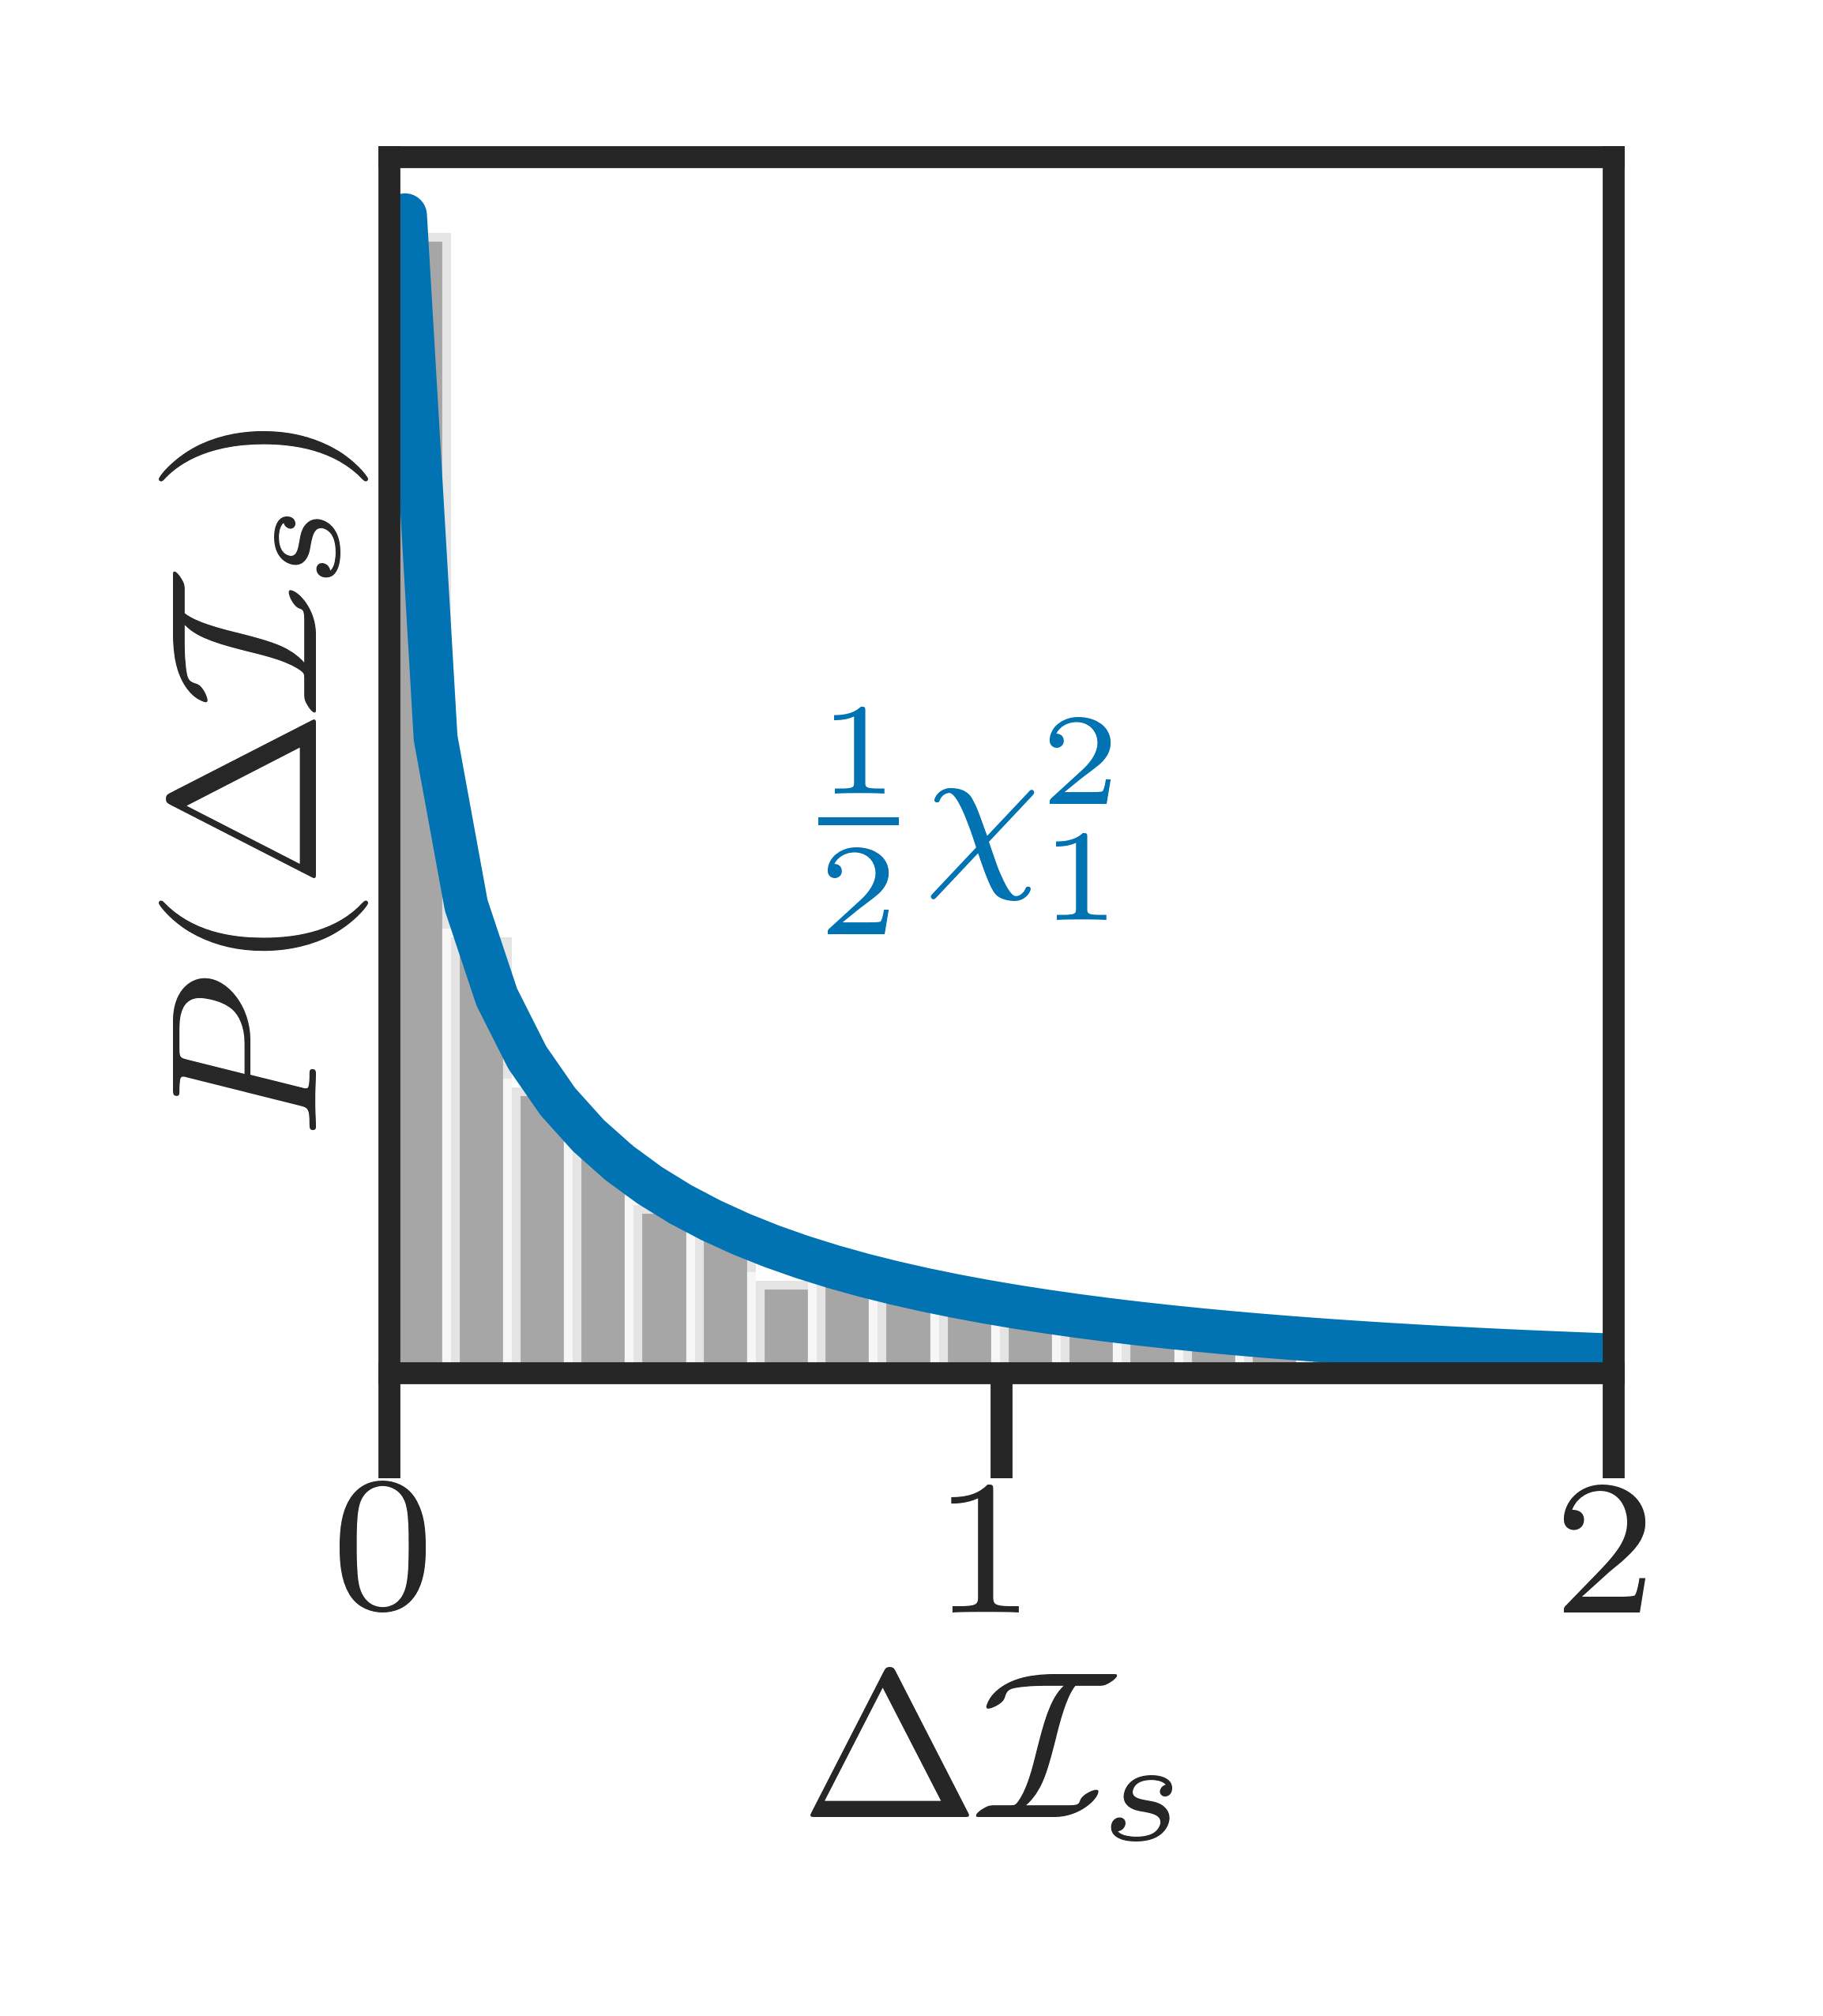

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotx

def plot_histo_p_delta_I(df, ax=None, x_max=2, key_info_delta="info_delta"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(1,1))
    # Filtering the dataframe as before
    base_tuple = tuple(model.index_real_base)
    filtered_df = df[df['nodes'].apply(
        lambda x: set(base_tuple).issubset(x) and len(x) == len(base_tuple) + 1
    )]
    info_vals = filtered_df[key_info_delta]
    counts, bins, patches = ax.hist(info_vals, bins=100, edgecolor='white', density=True, alpha=0.7, label='Empirical Dist.', color='gray')
    if key_info_delta == "info_delta":
        def f_Y(y):
            # Ensure domain: y > -1
            if y <= -1:
                return 0.0
            return math.exp(-y-1)/(math.sqrt(math.pi)*math.sqrt(y+1))
        x_min = -1
    else:
        def f_Y(y):
            # Ensure domain: y > -1
            if y <= 0:
                return 0.0
            return math.exp(-y)/(math.sqrt(math.pi)*math.sqrt(y))
        x_min = 0
    y_min, y_max = min(info_vals), max(info_vals)
    y_vals = np.linspace((bins[0]+0.5*bins[1])/2, y_max, 200)
    pdf_vals = [f_Y(y) for y in y_vals]
    color = ut.cmaps[0]
    print(color)
    ax.plot(y_vals, pdf_vals, color=color, lw=2, label='PDF of $Y = 0.5X - 1$ \n   where $X \sim \chi^2(1)$')
    _x = x_min + 0.7
    ax.text(_x, f_Y(0) + 2, r'$\frac{1}{2}\chi^2_1$', fontsize=8, verticalalignment='top', color=color)
    ax.set_xlabel('$\Delta \mathcal{I}_{s}$')
    ax.set_ylabel('$P(\Delta \mathcal{I}_{s})$')
    ax.set_xlim(0, x_max)
    ax.set_yticks([])
    return ax
    
plot_histo_p_delta_I(df, key_info_delta="info_delta_not_AIC")


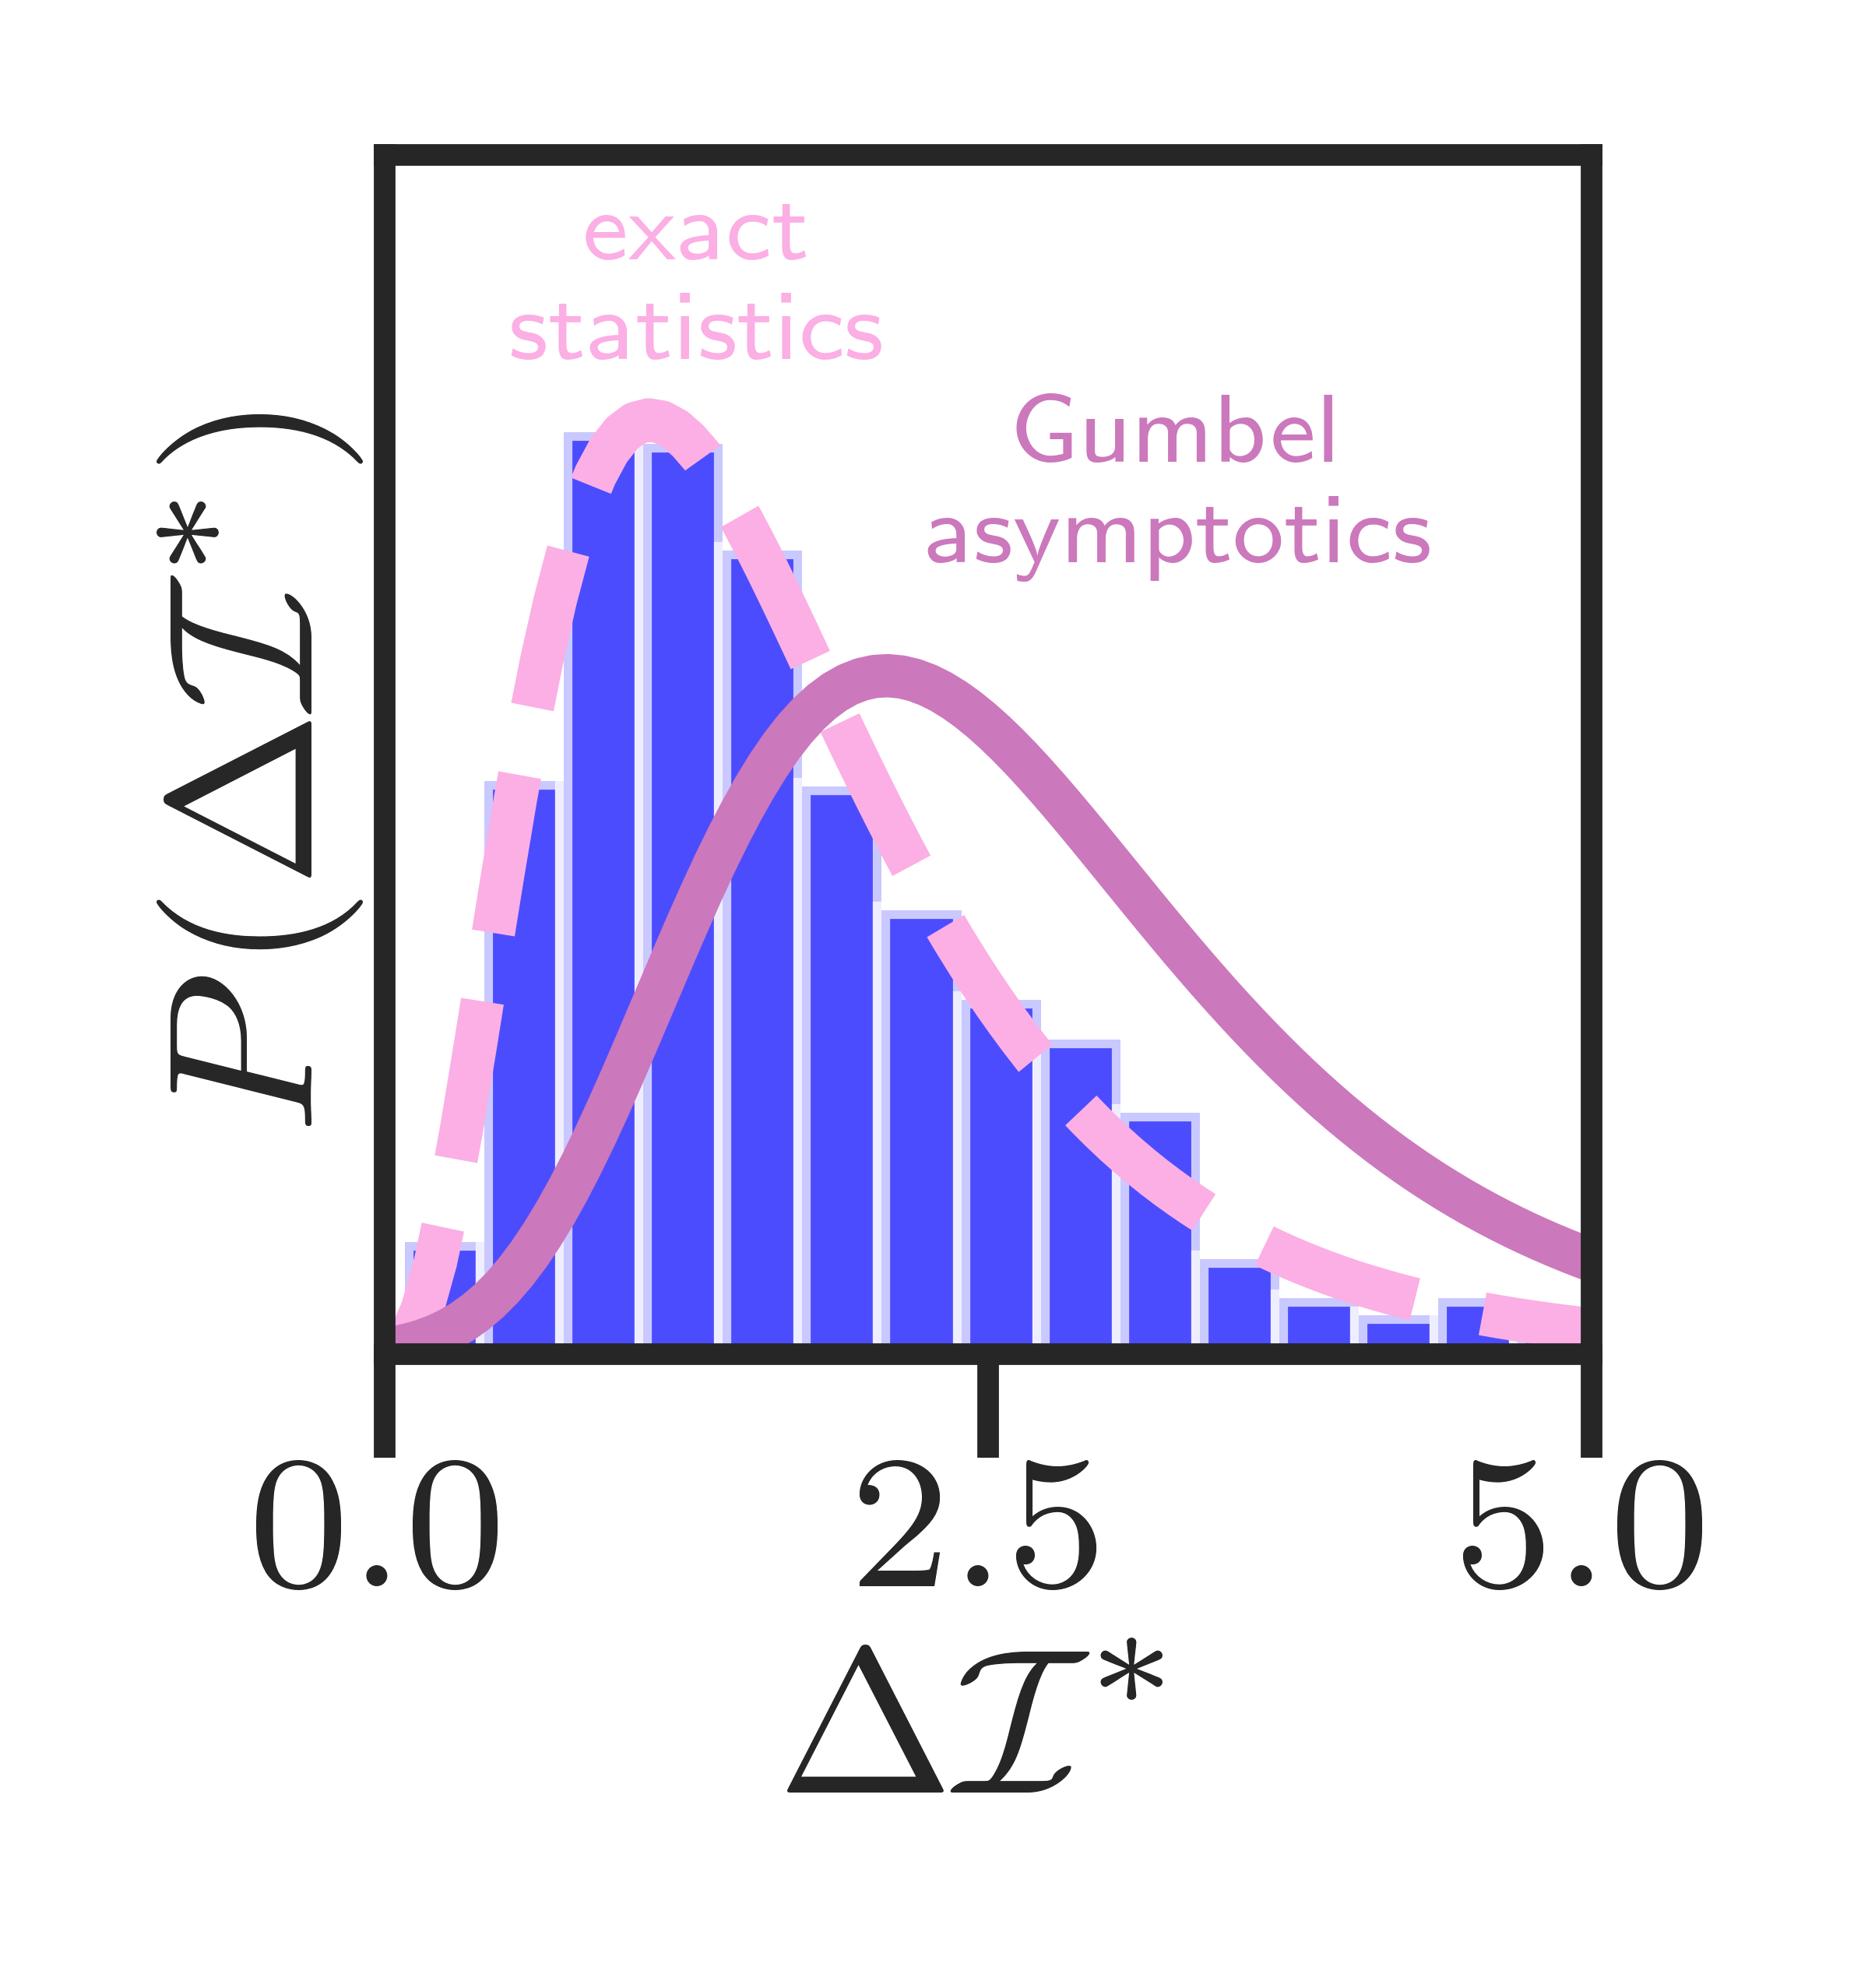

In [13]:
import numpy as np
from scipy.stats import norm
import scipy.special 

def pdf_max_chi2_1_sur_2(m, n):
    m = np.atleast_1d(m)
    valid = m > 0
    pdf_vals = np.zeros_like(m)
    m_1 = m[valid]
    pdf_vals[valid] = n/(np.sqrt(m_1)) * 1/np.sqrt(np.pi)*np.exp(-m_1) * scipy.special.erf(np.sqrt(m_1))**(n-1)
    return pdf_vals

def pdf_max_chi2_1_previous(m, n):
    """
    PDF of the maximum of n iid Chi-square(1) random variables.

    Parameters
    ----------
    m : float or array_like
        The value(s) at which to evaluate the PDF.
    n : int
        The number of iid Chi-square(1) random variables.

    Returns
    -------
    float or ndarray
        The PDF evaluated at m.
    """

    m = np.atleast_1d(m)
    valid = m > 0
    pdf_vals = np.zeros_like(m)
    cdf_chi_square = (2 * norm.cdf(np.sqrt(m[valid])) - 1)
    chi_square_pdf = (1 / np.sqrt(2 * np.pi * m[valid])) * np.exp(-m[valid] / 2)  
    pdf_vals[valid] = n * cdf_chi_square**(n-1) * chi_square_pdf
    return pdf_vals[0] if  pdf_vals.size == 1 else pdf_vals

    
def plot_histo_p_max_delta_I(df, ax=None, fontsize=5, cumulative=False, key_info_delta="info_delta"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(1,1))
    n_max = len(model.total_base)
    base_length = len(model.index_real_base)
    base_tuple = tuple(model.index_real_base)
    filtered_df = df[df['nodes'].apply(lambda x: set(base_tuple).issubset(x) and len(x) == base_length + 1)]
    max_info_delta = filtered_df.groupby('i_simu')[key_info_delta].max()

    counts, bins, patches = ax.hist(max_info_delta, bins=30, edgecolor='white', density=True, color="blue",
                                    cumulative=cumulative, alpha=0.7, label='Empirical Dist.')
    # Gumbel parameters
    free_param = n_max - base_length
    mu = 2*np.log(free_param) #- np.log(np.log(free_param)) - np.log(np.pi)  # location
    mu_2 = mu - np.log(np.log(free_param)) - np.log(2*np.pi)  # location
    beta = 2        # scale
    
    alpha = 3#0.5
    s = 2 #2/np.pi
    
    def variable_change(y):
        if key_info_delta == "info_delta":
            return 2*(y+1)
        else:    
            return 2*(y)
        
    # Original Gumbel PDF
    def gumbel_pdf(x, mu, beta):
        z = (x - mu) / beta
        return (1.0 / beta) * np.exp(-(z + np.exp(-z)))
    
    # Transformed Gumbel PDF for Y = 0.5X - 1
    def transformed_gumbel_pdf(y, mu, beta):
        x = variable_change(y)
        return 2 * gumbel_pdf(x, mu, beta)
    
    # def transform_pdf_chi2_1(y, n):
    #     x = variable_change(y)
    #     return 2*pdf_max_chi2_1_previous(x, n)

    # Generate a range of y-values over your data range
    y_min, y_max = min(max_info_delta), max(max_info_delta)
    y_values = np.linspace(-1, y_max, 200)
    pdf_values_approx = [transformed_gumbel_pdf(y, mu, beta) for y in y_values]
    pdf_values_approx_2 = [transformed_gumbel_pdf(y, mu_2, beta) for y in y_values]
    pdf_values = [pdf_max_chi2_1_sur_2(y, free_param) for y in y_values]
    #pdf_values = [gumbel_pdf(y, mu_rescaled, beta_rescaled) for y in y_values]
    if cumulative:
        pdf_values = np.cumsum(pdf_values)/np.sum(pdf_values)
        pdf_values_approx = np.cumsum(pdf_values_approx)/np.sum(pdf_values_approx)
    color = ut.cmaps_sns[-4]
    color_gumbel = ut.cmaps_sns[-6]
    ax.plot(y_values, pdf_values, '--', lw=2, label='Exact PDF', color=color)
    ax.text(1.3, 0.63, 'exact\nstatistics', fontsize=fontsize-0.5, verticalalignment='top', color=color, horizontalalignment='center')
    ax.text(3.3, 0.52, "Gumbel\nasymptotics", fontsize=fontsize-0.5, verticalalignment='top', color=color_gumbel, horizontalalignment='center')
    if not cumulative:
        ax.set_ylim(0, 0.65)
        ax.set_yticks([])
    ax.plot(y_values, pdf_values_approx, '-', lw=2, label='Gumbel approx', color=color_gumbel)
    #ax.plot(y_values, pdf_values_approx_2, '-', lw=2, label='Gumbel approx', color=ut.cmaps_sns[-5])
    ax.set_xlabel(r'$ \Delta \mathcal{I}^{*}$')
    ax.set_ylabel(r'$P(\Delta \mathcal{I}^{*})$')
    ax.set_xlim(0, 5)
    if cumulative:
        ax.xaxis.set_major_locator(plt.MultipleLocator(1))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))
    return ax

ax = plot_histo_p_max_delta_I(df, cumulative=False, key_info_delta="info_delta_not_AIC")

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)


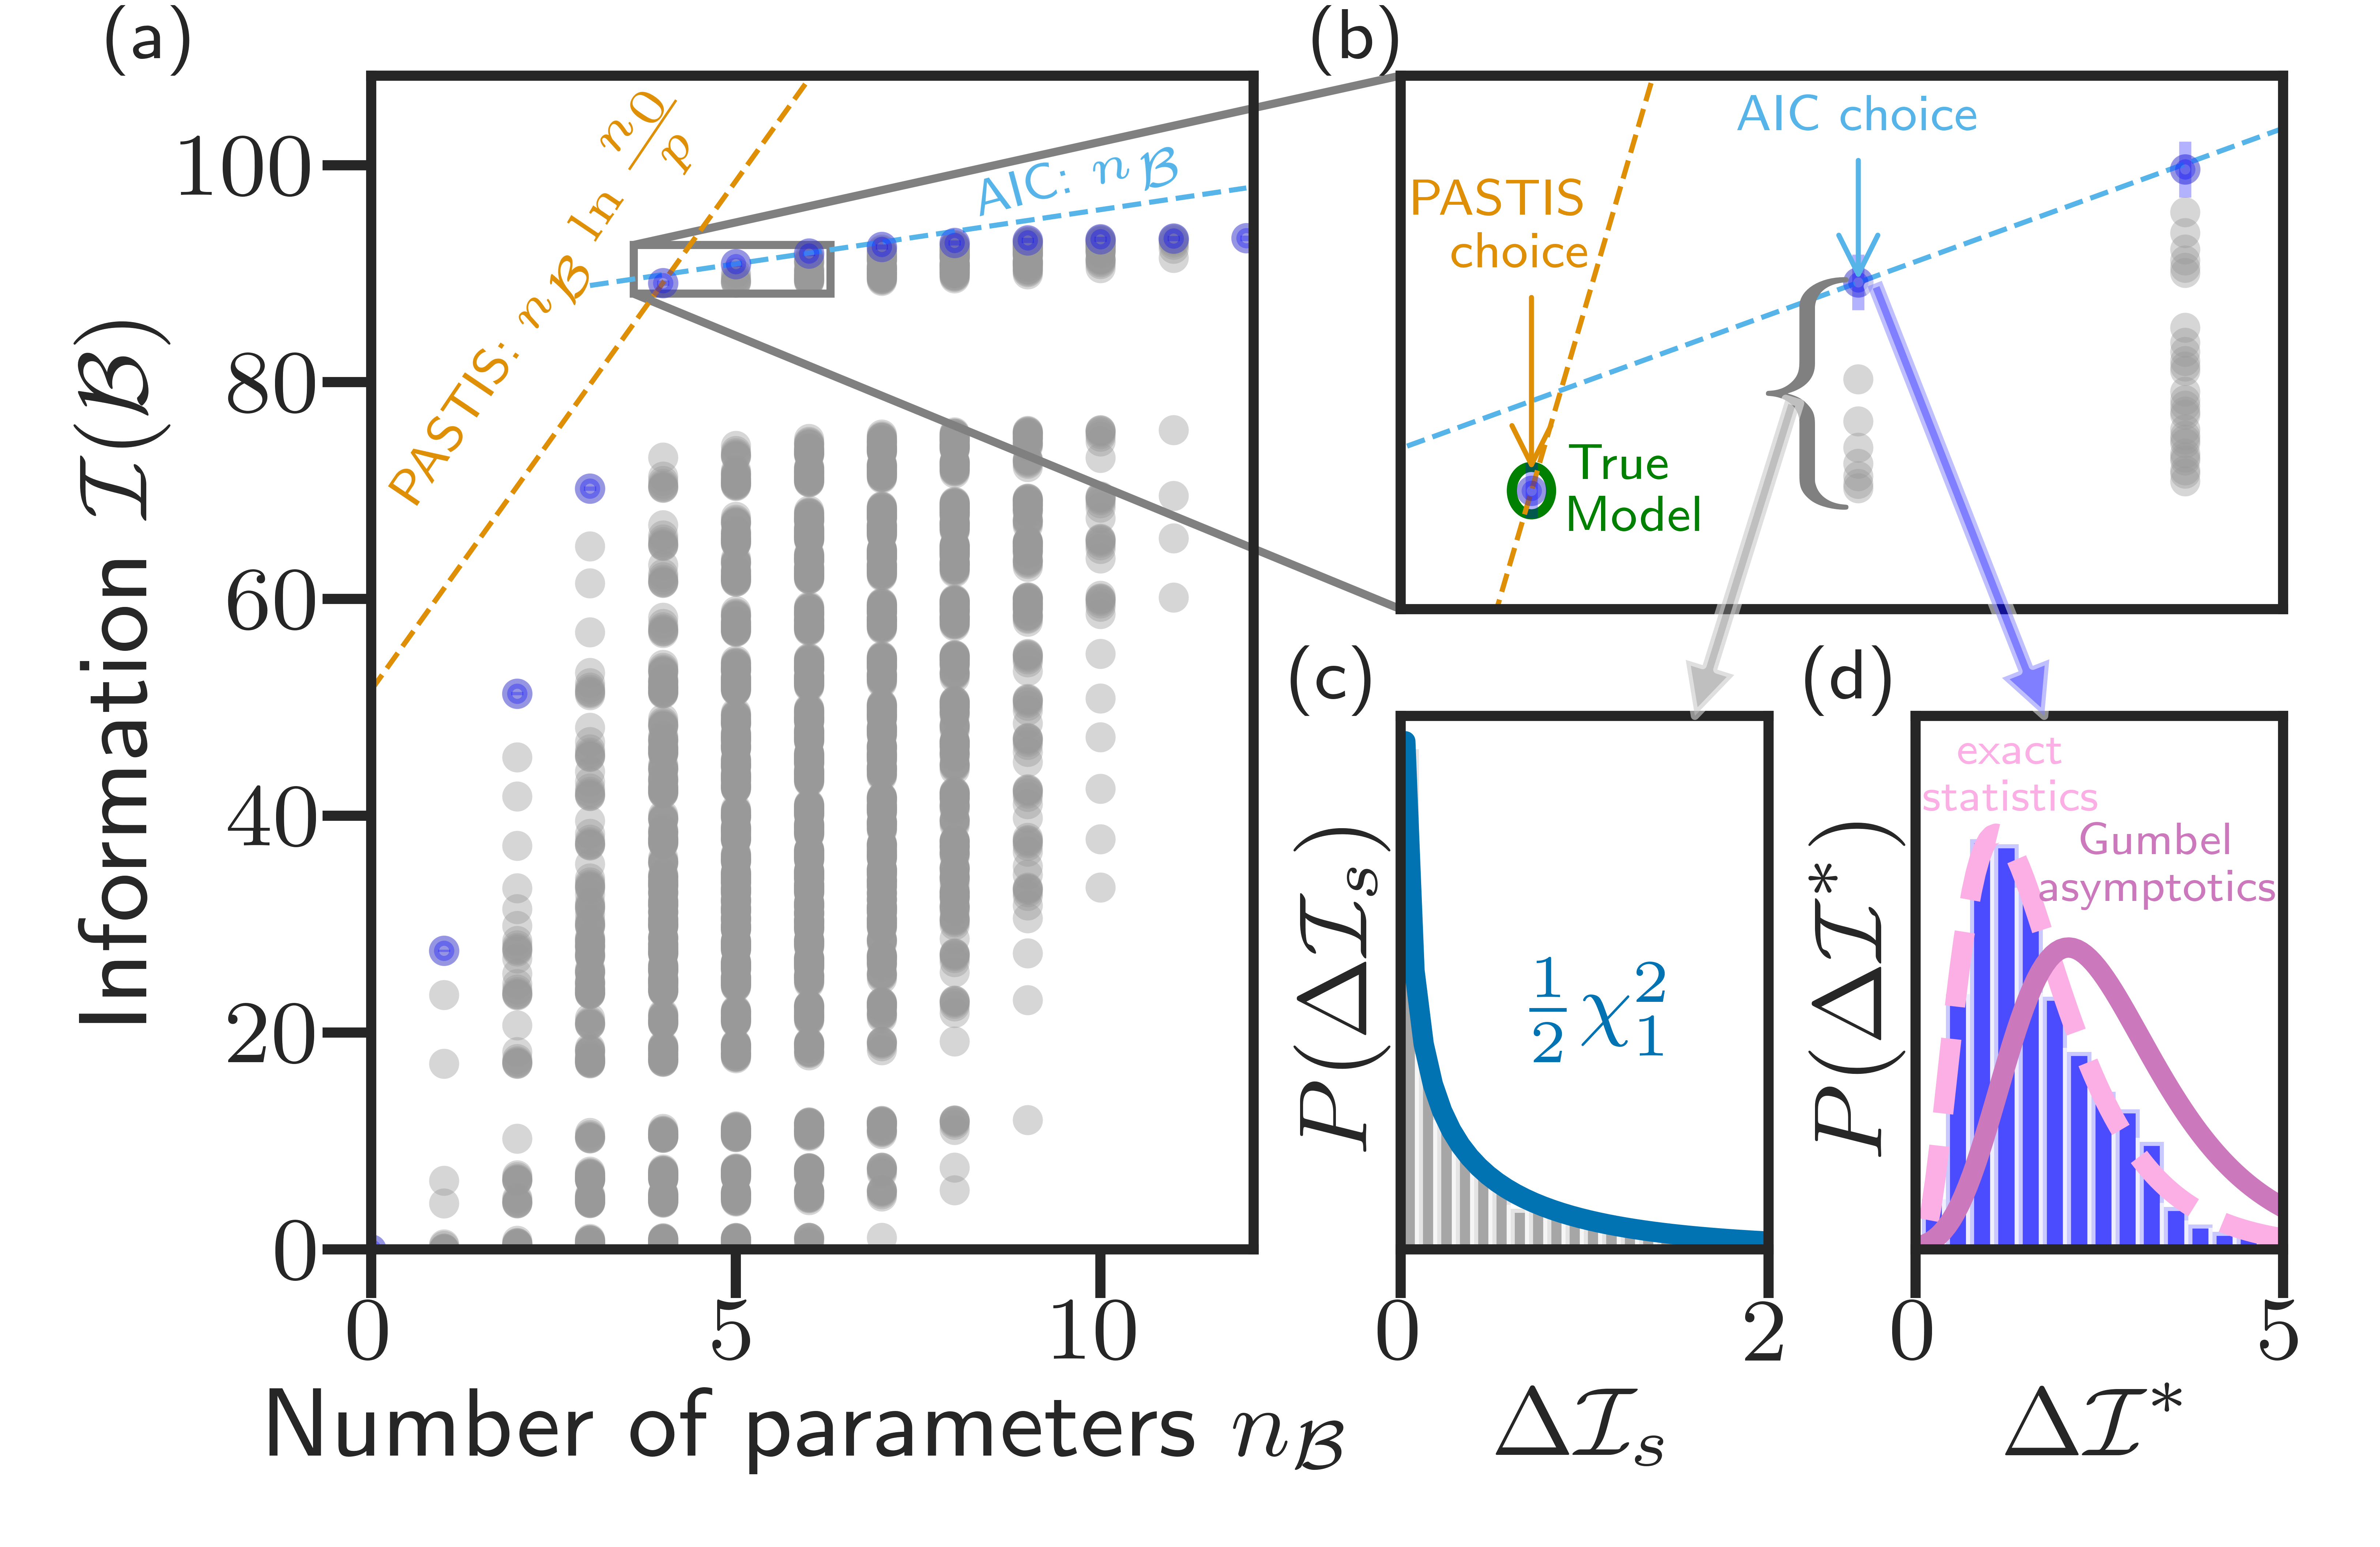

In [14]:
ut.set_favorite_plot_config(font_scale=1)
import matplotlib.gridspec as gridspec
# import pylustrator
# pylustrator.start()

# Create the figure and axes
n_rows, n_cols = 2, 4
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=ut.set_size(width="article", subplots=(2, 2), fraction=1), constrained_layout=True,)
gs = gridspec.GridSpec(
    n_rows, n_cols,          # 2 rows, 2 columns
    wspace=0.4,    # width space between subplots
)
for ax_i in axs:
    for ax in ax_i:
        ax.remove()
axbig = fig.add_subplot(gs[0:, 0:2])
axsmall = fig.add_subplot(gs[0, 2:])

axbig, axsmall, aspect_ratio = zoom(ax=axbig, axins=axsmall)
average_max_info = add_pareto_front(df, [axbig, axsmall], key_info=key_info)
    
add_text(axsmall, average_max_info, aspect_ratio)
    
ax_histo_1 = plot_histo_p_delta_I(df, ax=fig.add_subplot(gs[1, 2]), key_info_delta=key_info_delta)
ax_histo_2 = plot_histo_p_max_delta_I(df, ax=fig.add_subplot(gs[1, 3]), key_info_delta=key_info_delta)
add_lines_AIC_PASTIS(axbig, axsmall)

out = hf.add_letter(axbig, "a", y=1)
out = hf.add_letter(axsmall, "b", y=1, x=-0.1)
out = hf.add_letter(ax_histo_1, "c", y=1)
out = hf.add_letter(ax_histo_2, "d", y=1)

x1, x2 = len(model.index_real_base), len(model.index_real_base) + 1
y1, y2 = average_max_info[x1], average_max_info[x2]
arrow = plt.annotate('', xy=(0.8, 1), xytext=(x2-0.2, y2-1), 
                     xycoords=ax_histo_1.transAxes, textcoords=axsmall.transData,
                     arrowprops=dict(facecolor='grey', alpha=0.5, headwidth=5, width=1.5, headlength=5))
arrow.set_in_layout(False)
arrow = plt.annotate('', xy=(0.35, 1), xytext=(x2+0.05, y2-0.01),
                     xycoords=ax_histo_2.transAxes, textcoords=axsmall.transData,
                     arrowprops=dict(facecolor='blue', alpha=0.5, headwidth=5, width=1.5, headlength=5))
arrow.set_in_layout(False)

plt.figure(1).axes[0].texts[0].set(position=(8.226, 93.69), rotation=15.)
plt.figure(1).axes[0].texts[1].set(position=(0.0181, 66.73))
plt.figure(1).axes[1].texts[4].set(position=(4.895, 90.97))
plt.figure(1).axes[1].texts[5].set(position=(4.114, 89.56))
plt.savefig("figures/OrnsteinUhlenbeck_dim_3_figure_2.png", dpi=2000, bbox_inches='tight')